In [ ]:
%%bash
pip install pycocotools
pip install tensorboard

In [1]:
import sys
sys.path.append('..')
import time
import uuid
import torch.nn.functional as F
import torchvision.transforms.functional as FT
from functools import partial
from torch import nn
from dataset import CocoDataset
from utils   import *
from model   import *
from metric  import *
from loss    import *
from torch_exp.learner import Learner
DEVICE = 'cpu' if torch.cuda.device_count() == 0 else 'cuda:0'
print(DEVICE)

cuda:0


# DATA

## Data transformations, dataset, & dataloader

Below we define the **sequence of transformations** to apply on the training and validation datasets (and demo dataset) for image augmentation and preprocessing. Individual **datasets** are built using different transformation sequences, mainly because image augmentation should not apply when performing inferencing/prediction on the validation dataset. Finally, **dataloaders** are built from the the dataset objects with a defined batch size.

In [2]:
# define the sequence of transformations to apply to each image sample 
img_sz = 300


# different transform operations for train, valid and demonstration purposes
distort_tfms  = [PhotometricDistort(1.),
                 Flip(0.5)]
zoom_tfms     = [Zoomout(0.5, max_scale=2.5)]
toTensor_tfms = [ImageToTensor(), 
                 CategoryToTensor(), 
                 BoxToTensor()]
resize_tfms   = [Resize((img_sz, img_sz)),
                 CocoBoxToFracBoundaryBox()]
imgNorm_tfms  = [Normalize()]


# composing the different transforms
train_tfms = transforms.Compose(distort_tfms + toTensor_tfms + zoom_tfms + imgNorm_tfms + resize_tfms)
val_tfms   = transforms.Compose(toTensor_tfms + imgNorm_tfms + resize_tfms)
demo_tfms  = transforms.Compose(distort_tfms + toTensor_tfms + zoom_tfms)

# instantiate the dataset object
ds_train = CocoDataset(data_dir='..', dataset='train2017', anno_type='instances', transforms=train_tfms)
ds_demo  = CocoDataset(data_dir='..', dataset='train2017', anno_type='instances', transforms=demo_tfms)
ds_valid = CocoDataset(data_dir='..', dataset='val2017',   anno_type='instances', transforms=val_tfms)


# create dataloaders
BS = 32
dl_train = DataLoader(ds_train, batch_size=BS, shuffle=True,
                      collate_fn=partial(ds_train.collate_fn, img_resized=True)) # img_resized=true to indicate all image samples have been resized to same shape

dl_valid = DataLoader(ds_valid, batch_size=BS, shuffle=True,
                      collate_fn=partial(ds_valid.collate_fn, img_resized=True)) # img_resized=true to indicate all image samples have been resized to same shape


loading annotations into memory...
Done (t=18.95s)
creating index...
index created!
loading annotations into memory...
Done (t=17.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


## Examine Dataset

Lets' examine the structure of the dataset and its dataloader to get a better sense of input and target label structures. The dataset is a dictionary consisting of keys for:
- image: input into model
- segs: target for image segmentation tasks (NOT PREPROCESSED and NOT applicable to this project)
- cats: target for image classification task (applicable to this project)
- boxes: target for image locationlization task (applicable to this project)
- dims: meta data for the original image size before any preprocesssing transformations

In [3]:
ds_train[4].keys()

dict_keys(['image', 'segs', 'cats', 'boxes', 'dims'])

### Image (& Augmentations)

The examples below illustrates the variety of transformations done on the original image for the purpose of **data augmentation** while training the model (the first image is the original, untransformed image). These transformations only applies to the training dataset and NOT on the validation dataset or when performing prediction tasks. 

Note the bounding boxes are in yellow color and are scaled appropriately with each transformation.

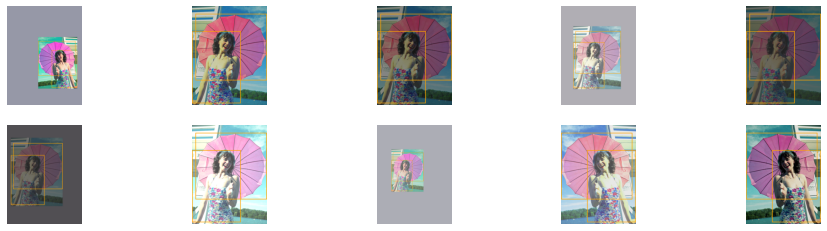

In [4]:
show_augmented_samples(ds_demo, sample_idx=4)

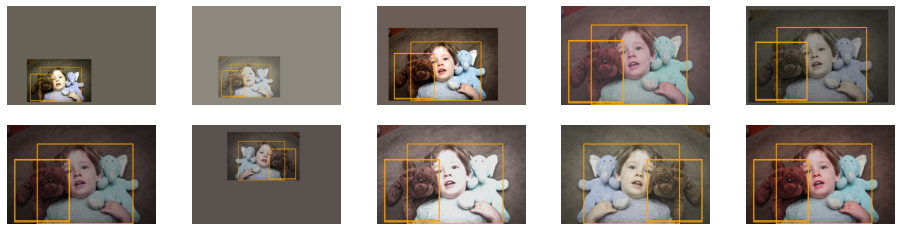

In [5]:
show_augmented_samples(ds_demo, sample_idx=4958)

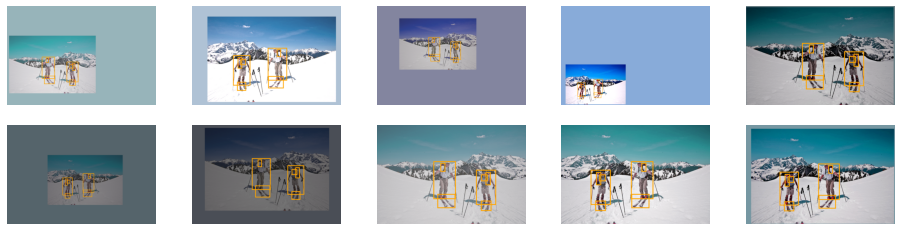

In [6]:
show_augmented_samples(ds_demo, sample_idx=19763)

### Bounding Boxes

The target bounding boxes are expressed in **fractional** form in **boundary coordinates**. This means the bounding box coordinates are expressed in terms of $(x_{min}, y_{min}, x_{max}, y_{max})$ where $(x_{min}, y_{min})$ is the top left corner and $(x_{max}, y_{max})$ is the lower right corner of the bounding box. **The fractional form means that $(x, y)$ is expressed as a fraction of the images' original dimensions.**

Note the fractional transform on the boundary boxes is done via the `CocoBoxToFracBoundaryBox` transformation. The sample below validates the bounding box coordinates from the training dataset is within $[0,1]$ range.

In [7]:
ds_train[4]['boxes']

tensor([[0.3819, 0.3490, 0.9380, 0.7420],
        [0.3570, 0.4520, 0.7344, 0.8768]])

### Class Labels

The target labels are kept in their original class index form.

In [8]:
ds_train[4]['cats']

tensor([26,  1])

## Examine DataLoader

The dataloader is responsible for concatenating all images, bounding boxes, and class labels from all samples within a sample batch, sampled from the dataset object. Below we extract one batch from the training dataloader to examine its structure. It returns a dictionary with the same set of keys as the dataset object previously.

In [9]:
sample_batch = next(iter(dl_train))
sample_batch.keys()

dict_keys(['images', 'segs', 'cats', 'boxes', 'dims'])

### Images

The image tensors have been concatenated along the batch-index axis into one single tensor. Note this is only possible because each individual image has been resized into the same dimensions as defined by `img_sz = 300`.

In [10]:
sample_batch['images'].size()

torch.Size([16, 3, 300, 300])

### Boxes & Labels

Each image in a batch contains varying number of object of interest. As such, they cannot be concatenated into a single tensor like what was done on the image batch. Instead, they are returned by the dataloader as a list of tensors, where each tensor is of dimensions $(n_{i}, 4)$ for bounding boxes and $(n_{i})$ for category labels - where $n_{i}$ is the number of objects in each image.

In [11]:
len(sample_batch['boxes'])

16

In [12]:
print(f"boxes dimension for first image:  {sample_batch['boxes'][0].size()}")
print(f"boxes dimension for second image: {sample_batch['boxes'][1].size()}")
print(f"boxes dimension for third image:  {sample_batch['boxes'][2].size()}")

boxes dimension for first image:  torch.Size([15, 4])
boxes dimension for second image: torch.Size([7, 4])
boxes dimension for third image:  torch.Size([19, 4])


In [13]:
sample_batch = next(iter(dl_train))
sample_batch['boxes'][0]

tensor([[0.3545, 0.1055, 0.7774, 0.6297]])

In [14]:
print(f"category dimension for first image:  {sample_batch['cats'][0].size()}")
print(f"category dimension for second image: {sample_batch['cats'][1].size()}")
print(f"category dimension for third image:  {sample_batch['cats'][2].size()}")

category dimension for first image:  torch.Size([1])
category dimension for second image: torch.Size([3])
category dimension for third image:  torch.Size([1])


# DBATCH

Finally we use a `Data` class object as a thin wrapper around the different dataloaders prepared.

In [3]:
class Data():
    def __init__(self, train_dl, valid_dl):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        

In [4]:
# create a data obj that wraps around train/valid dls
data = Data(train_dl=dl_train,
            valid_dl=dl_valid)


# MODEL

Create the SSD300 model by specifying the number of class categories in the training dataset. The main components of SSD are:
- base: leveraging the pre-trained layers VGG16 as base architecture
- aux: auxiliary component 
- pred: prediction layers for localization + classification prediction output

In [5]:
# create the SSD model
ssd = SSD300(n_classes=len(ds_train.id2cat), device=DEVICE)

# freeze baselayer to train aux/pred layers first
# ssd.fine_tune()


# COST

In [6]:
# multi-loss criteria
loss_fcn = MultiBoxLoss(ssd.prior_boxes,
                        threshold=0.5, 
                        neg_pos_ratio=3, 
                        alpha=1.,
                        device=DEVICE)


# METRIC

In [7]:
# mean-avg precpision as metric
metric = mAP(n_classes=ssd.n_classes, device=DEVICE)


# EXPERIMENT

In [8]:
from torch_exp.exp import SupervisedExp
from torch_exp.callbacks import CocoDataBatchCallback, TensorBoardCallback

# create a learner; wrapper around the mode, cost_func, metric & data
learner = Learner(ssd, loss_fcn, metric, data)

# create a Torch Experiment!
exp = SupervisedExp(learner, 
                    cb_funcs=[CocoDataBatchCallback, TensorBoardCallback],
                    name='SSD', desc='object detection',                    
                    eval_every_n_epoch=5,
                    save_every_n_epoch=5)


# TRAIN

### LR finder

In [10]:
from torch_exp.utils import LrFinder

MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

# init optimizer
opt = torch.optim.SGD(params=[{'params': exp.biases}, {'params': exp.weights}],
                      lr=1e-3, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


[0/1] epochs |                 [25/7393] iterations |                 current train loss: 257977.99682617188 |                 avg. train loss: 254343.44482421875
[0/1] epochs |                 [50/7393] iterations |                 current train loss: 240181.5643310547 |                 avg. train loss: 244123.74877929688
[0/1] epochs |                 [75/7393] iterations |                 current train loss: 203552.96325683594 |                 avg. train loss: 233545.81115722656
[0/1] epochs |                 [100/7393] iterations |                 current train loss: 219997.4365234375 |                 avg. train loss: 223348.0125427246
[0/1] epochs |                 [125/7393] iterations |                 current train loss: 151265.60974121094 |                 avg. train loss: 214436.2857055664
[0/1] epochs |                 [150/7393] iterations |                 current train loss: 113667.77038574219 |                 avg. train loss: 205643.2056172689
[0/1] epochs |          

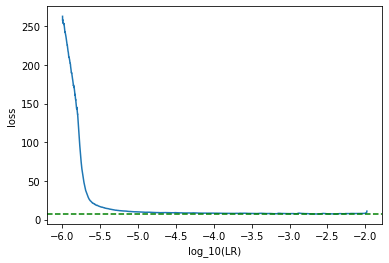

[0/1] epochs |                 [0/7393] iterations |                 current train loss: 2855695250.0 |                 avg. train loss: 691122.5047224883
checkpoint loaded; resume training from epoch 0.0


In [13]:
# run LR-find routine to find appropriate LR
lrf = LrFinder(exp, opt, lr_start=1e-6)
lrf.run()


## Train 1 epoch

In [9]:
EPOCHS = 1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

# init optimizer
opt = torch.optim.SGD(params=[{'params': exp.biases}, {'params': exp.weights}],
                      lr=1e-3, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


In [10]:
# add gradient clipping callback to experiment to prevent gradient explosion
from torch_exp.callbacks import GradientClipCallback
# add oneCycle policy training
from torch_exp.callbacks import OneCycleCallback

# gradient clip callback for safety
gc_cb = GradientClipCallback(1e3)

# one cycle train callback for faster convergence
oc_cb = OneCycleCallback(max_lr=1e-3, 
                         scheduler_kwargs={'epochs': EPOCHS, 
                                           'steps_per_epoch': len(dl_train), 
                                           'pct_start': 0.3})

# add training callbacks
exp.add_callback([gc_cb, oc_cb])


In [ ]:
# train
exp.run(EPOCHS, opt)


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[0/1] epochs |                 [25/3697] iterations |                 current train loss: 27099.931716918945 |                 avg. train loss: 96794.03671264648
[0/1] epochs |                 [50/3697] iterations |                 current train loss: 14485.278129577637 |                 avg. train loss: 57920.20067214966
[0/1] epochs |                 [75/3697] iterations |                 current train loss: 14567.525863647461 |                 avg. train loss: 43238.31671396891
[0/1] epochs |                 [100/3697] iterations |                 current train loss: 11653.494834899902 |                 avg. train loss: 35456.12442970276
[0/1] epochs |                 [125/3697] iterations |                 current train loss: 8855.12638092041 |                 avg. train loss: 30481.265426635742
[0/1] epochs |                 [150/3697] iterations |                 current train loss: 9681.086540222168 |                 avg. train loss: 27060.956071217854
[0/1] epochs |            

In [ ]:
# save after 1-epoch
exp.save(opt=opt)

# Train Epoch 2

In [14]:
# load from previous checkpoint
exp.load('./runs/exp_b9470dd1-f618-4023-8df2-2683a3df879d/1epochs.pth.tar', DEVICE)

checkpoint loaded; resume training from epoch 1.0


In [ ]:
exp.run(EPOCHS, opt)

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1/1] epochs |                 [3700/3697] iterations |                 current train loss: 5556.8647384643555 |                 avg. train loss: 6171.6915766398115
[1/1] epochs |                 [3725/3697] iterations |                 current train loss: 6299.006938934326 |                 avg. train loss: 6424.773097038269
[1/1] epochs |                 [3750/3697] iterations |                 current train loss: 6572.089672088623 |                 avg. train loss: 6484.101871274553
[1/1] epochs |                 [3775/3697] iterations |                 current train loss: 6357.367038726807 |                 avg. train loss: 6497.558985001002
[1/1] epochs |                 [3800/3697] iterations |                 current train loss: 6386.953353881836 |                 avg. train loss: 6476.4990065861675
[1/1] epochs |                 [3825/3697] iterations |                 current train loss: 6240.589141845703 |                 avg. train loss: 6495.9876537323
[1/1] epochs |       

# Predict

In [13]:
# load model checkpoint
chkpt = torch.load('./runs/exp_b9470dd1-f618-4023-8df2-2683a3df879d/1epochs.pth.tar', map_location=DEVICE)
ssd = chkpt['model']
ssd.device = DEVICE

# import imageFont for drawing text
from PIL import ImageFont

In [26]:
# get a batch of data
d_batch = next(iter(dl_valid))
images, true_cats, true_boxes, img_dims = d_batch['images'], d_batch['cats'], d_batch['boxes'], d_batch['dims']

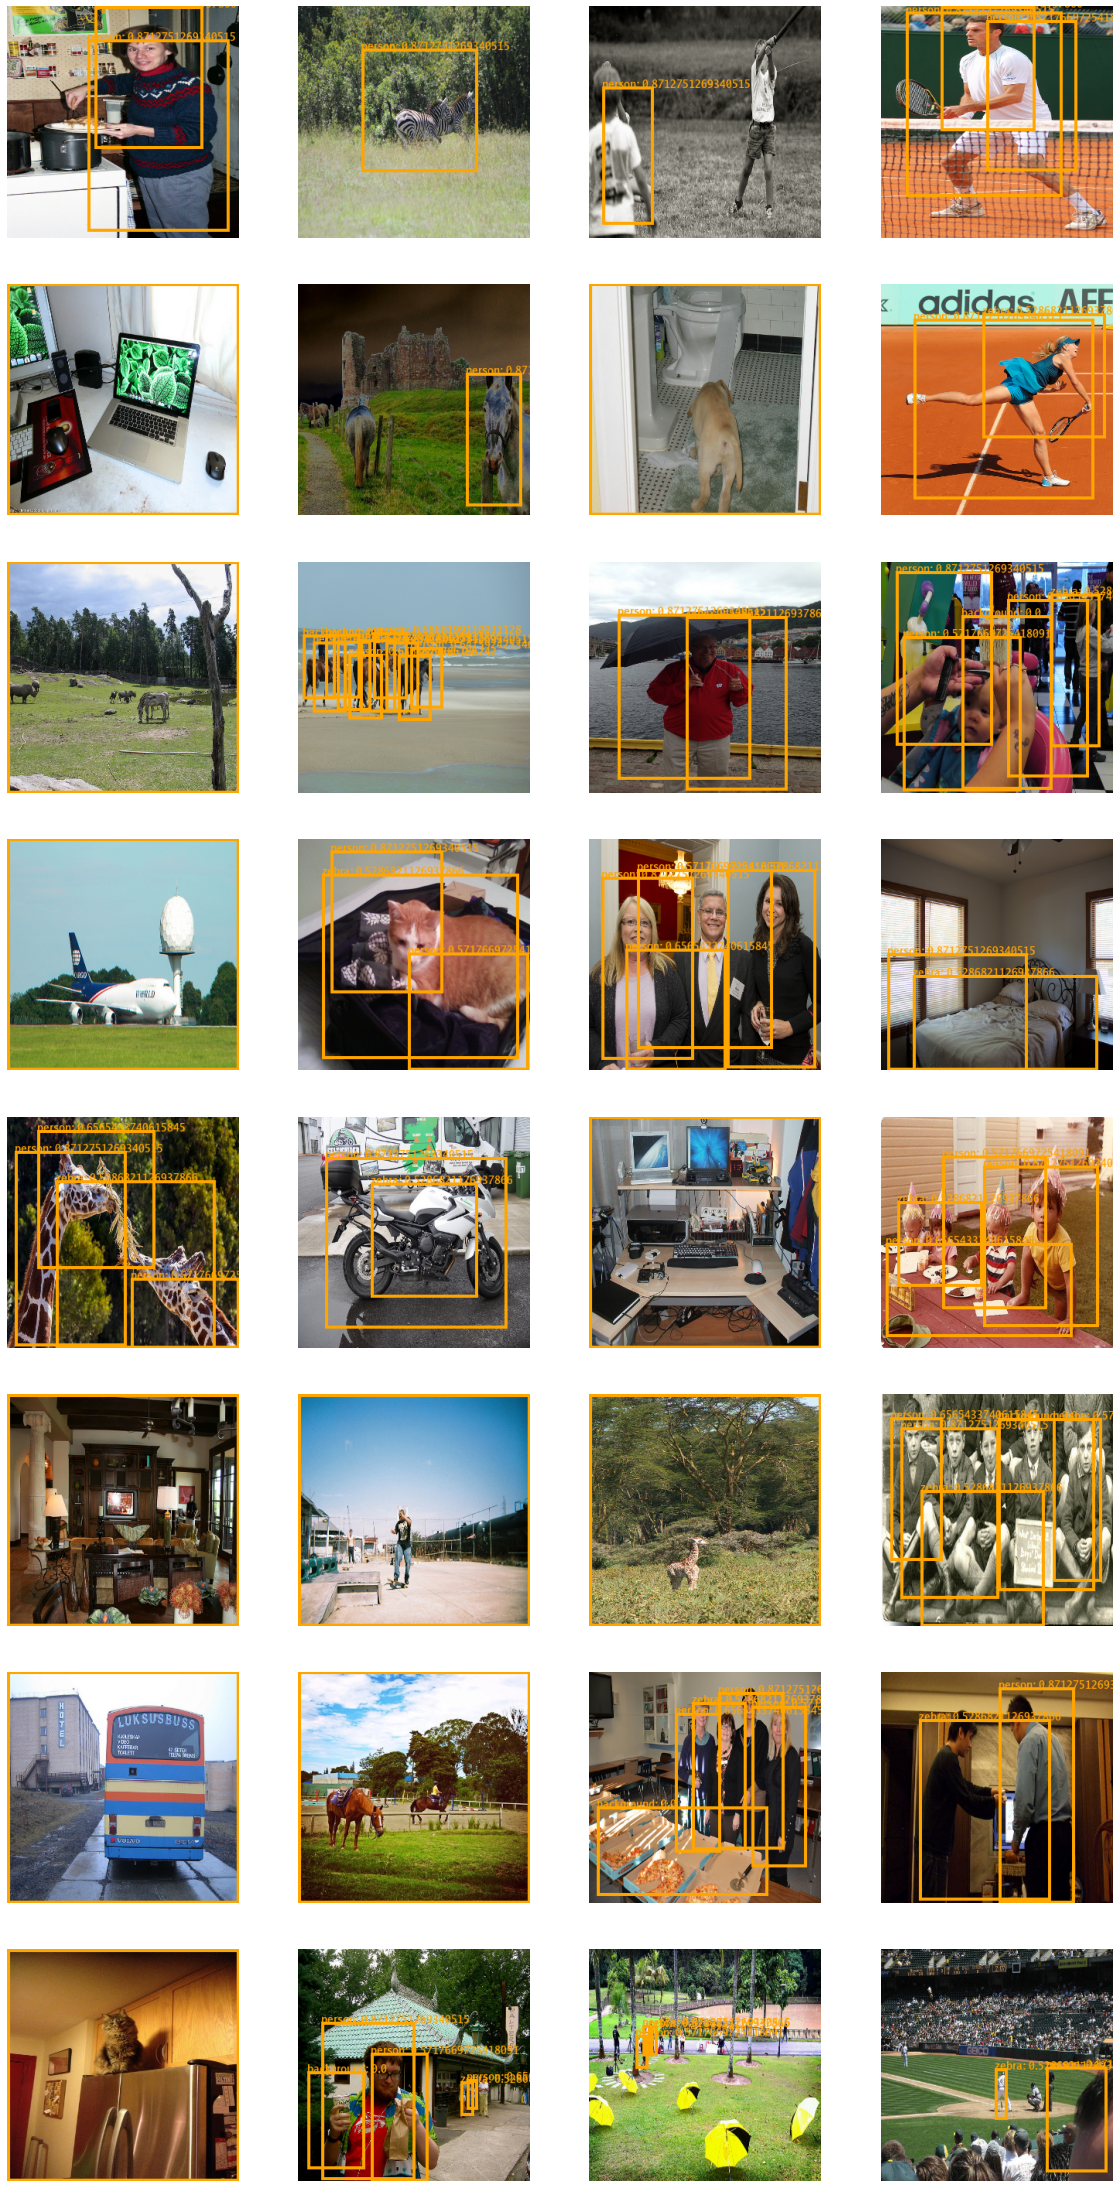

In [27]:
# inference
locs, scores = ssd(images.to(DEVICE))
detected_boxes, detected_labels, detected_scores = ssd.detect_objects( \
      locs, scores, \
      min_score_threshold=0.3, \
      max_overlap_threshold=0.4, \
      top_k=20 \
    )


# show prediction results
plt.figure(figsize=[20,40])
tf = transforms.ToPILImage()
normalize = Normalize()
font = ImageFont.truetype("../../../usr/share/fonts/fonts-go/Go-Medium.ttf", 14)
for i, (boxes, dim) in enumerate(zip(detected_boxes, img_dims)):
    # get image
    image = images[i]    
    # de-normalize image
    normalize.decode(image)
    # convert to PIL image
    image = tf(image)
    plt.subplot(8,4,i+1)
    draw = ImageDraw.Draw(image, 'RGBA')
    # clamp bounding box coordinates btw [0,1]
    bboxes = torch.clamp(boxes, min=0, max=1)
    for i in range(bboxes.shape[0]):
        # draw bounding box
        draw.rectangle(bboxes[i,:].detach().numpy()*300, outline='orange', width=4)
        # get object class name
        obj_name = ds_valid.id2cat[detected_labels[i].detach().numpy()[0]]
        # get object classificaiton score
        obh_score = detected_scores[i].detach().numpy()[0]
        # draw object label + score above the top-left corner of bounding box
        txt_coord = bboxes[i,:2].detach().numpy()*300 + np.array([0,-12])
        draw.text(xy=(txt_coord[0], txt_coord[1]),
                  fill='orange',
                  font=font,
                  text=f"{obj_name}: {obh_score}")
    plt.imshow(image); plt.axis('off')
    
    # # convert detected boxes back into original image coordinates
    # # in boundary coordinate format
    # coords = [bboxes[:,0]*dim[0], bboxes[:,1]*dim[1], bboxes[:,2]*dim[0], bboxes[:,3]*dim[1]]
    # bboxes = torch.cat([c.unsqueeze(-1) for c in coords], dim=-1)